As in Module 1, we will implement a relatively thin wrapper around `cmdstanpy`'s `CmdStanModel` class. This abstract base class (ABC) is effectively the same as our [`IslandEffectsModel` ABC](../island-effects/model-fitting-and-comparison.ipynb#generalizing-to-other-models). The important differences are: (i) that it accepts `kwargs` in `StanModel.__init__`, which we will use to pass in information for setting the priors on the by-context or by-verb intercepts; and (ii) that we don't implement a default `StanModel.construct_model_data` method. The reason for not implementing this method is that we will use `StanModel` as an ABC for both the norming models and the projection models.

In [130]:
from abc import ABC, abstractmethod, abstractproperty
from typing import Optional
from cmdstanpy import CmdStanModel
from typing import Optional
from enum import Enum
from dataclasses import dataclass
from pandas import DataFrame
from arviz import InferenceData, from_cmdstanpy

class StanModel(ABC):
    """An abstract base class for STAN models"""

    def __init__(self, **kwargs):
        self.model = CmdStanModel(stan_file=self.stan_file)
        self.init_params = kwargs

    @abstractproperty
    def stan_file(self) -> str: 
        raise NotImplementedError
        
    @abstractmethod
    def construct_model_data(self, data: DataFrame) -> dict:
        raise NotImplementedError

    def _validate_data(self) -> None:
        self.data_class(**self.model_data)

    def fit(
        self, 
        data: DataFrame,
        save_dir: Optional[str] = None,
        verbose: bool = False,
        map_initialization: bool = True,
        seed: int = 40392,
        iter_warmup: int = 50_000,
        iter_sampling: int = 50_000,
        **kwargs
    ) -> InferenceData:
        if verbose:
            print("Constructing model data...")
            
        self.model_data = self.construct_model_data(data)
        
        self._validate_data()
        
        if map_initialization:
            if verbose:
                print("Fitting model with MAP initialization...")

            map_estimate = self._compute_map_estimate(seed)
            
            if "inits" in kwargs:
                # inits passed to fit() should override MAP
                map_estimate.update(kwargs["inits"])

            kwargs["inits"] = map_estimate
        
        elif verbose:
            print("Fitting model...")
        
        # sample from the posterior starting at the MAP
        self.raw_model_fit = self.model.sample(
            data=self.model_data,
            iter_warmup=iter_warmup,
            iter_sampling=iter_sampling,
            **kwargs
        )
    
        if save_dir is not None:
            if verbose:
                print("Saving model...")

            self.save(save_dir)
            
        if verbose:
            print("Running MCMC diagnostics...")
            print()
            print(self.diagnose())
    
        return self
    
    def _compute_map_estimate(self, seed: int) -> dict:
        # compute MAP fit
        self.map_model_fit = self.model.optimize(
            data=self.model_data,
            seed=seed,
        )

        return self.map_model_fit.stan_variables()
    
    @property
    def model_fit(self) -> InferenceData:
        return from_cmdstanpy(
            self.raw_model_fit,
            coords=self.coords,
            dims=self.dims
        )
    
    def save(self, save_dir: str = "."):
        self.raw_model_fit.save_csvfiles(save_dir)
    
    @classmethod
    def from_csv(cls, path: str, **kwargs) -> 'StanModel':
        model = cls(**kwargs)
        model.raw_model_fit = cmdstanpy.from_csv(path)
        
    def diagnose(self) -> str:
        return self.raw_model_fit.diagnose()

Also as in Module 1, we'll want a way of mapping (or *hashing*) columns of our data to indices, which we'll use for hashing verb, context, and subject identifiers. This version of `hash_series` additionally allows us to specify the hashmap via the `categories` parameter, which will be necessary for ensuring we are associating the correct prior on by-context intercepts with the correct context.

In [131]:
from numpy import ndarray
from pandas import Series, CategoricalDtype

def hash_series(series: Series, categories: Optional[list[str]] = None, indexation: int=1) -> tuple[ndarray, ndarray]:
    """Hash a series to numeric codes
    
    Parameters
    ----------
    column
        The series to hash
    index
        The starting index (defaults to 1)
    """
    # enforce 0- or 1-indexation
    if indexation not in [0, 1]:
        raise ValueError("Must choose either 0- or 1-indexation.")
    
    # convert the series to a category
    if categories is None:
        category_series = series.astype("category")
    else:
        cat_type = CategoricalDtype(categories=categories)
        category_series = series.astype(cat_type)
    
    # get the hash
    hash_map = category_series.cat.categories.values
    
    # map to one-indexed codes
    hashed_series = (category_series.cat.codes + indexation).values
    
    return hash_map, hashed_series

## Model of prior beliefs

Our model for estimating prior beliefs from Degen and Tonhauser's norming data will subclass `StanModel` ABC and look similar to the models we wrote for Module 1. The main addition we make is a property `NormingModel.context_posterior_estimates` which returns estimates of $\mu^\text{context}_c$ and $\sigma^\text{context}_c$, assuming that $\rho_c \mid \mathbf{y}_\text{norming} \sim \mathcal{N}(\mu^\text{context}_c, \sigma^\text{context}_c)$.

In [132]:
from scipy.stats import norm
from pandas import merge

@dataclass
class NormingData:
    N_resp: int                  # number of responses
    N_context: int               # number of contexts
    N_subj: int                  # number of subjects
    context: ndarray             # context corresponding to response n
    subj: ndarray                # subject who gave response n
    resp: ndarray                # likert scale acceptability judgment responses

class NormingModel(StanModel):
    """A STAN model for Degen and Tonhauser's (2021) norming data"""
    
    stan_file = "models/norming-model/norming-model.stan"
    data_class = NormingData
    
    def __init__(self):
        super().__init__()
    
    def construct_context_info(self, data: DataFrame):
        self.context_info = data[["item", "prompt", "fact"]].drop_duplicates(ignore_index=True)
        self.context_info = self.context_info.rename(columns={"item": "context"})
    
    def construct_model_data(self, data: DataFrame):
        self.construct_context_info(data)
        
        if hasattr(self, "subj_hash_map"):
            _, subj_hashed = hash_series(data.workerid, self.subj_hash_map)
        else:
            self.subj_hash_map, subj_hashed = hash_series(data.workerid)
            
        if hasattr(self, "context_hash_map"):
            _, context_hashed = hash_series(data.item, self.context_hash_map)
        else:
            self.context_hash_map, context_hashed = hash_series(data.item)
        
        self.coords = {
            "subj": self.subj_hash_map,
            "context": self.context_hash_map
        }
        
        self.dims = {
            "context_intercept": ["context"],
            "context_prob": ["context"],
        }
        
        self.model_data = {
            "N_resp": data.shape[0],
            "N_context": self.context_hash_map.shape[0],
            "N_subj": self.subj_hash_map.shape[0],
            "context": context_hashed,
            "subj": subj_hashed,
            "resp": data.response.astype(float).values
        }
        
        return self.model_data
    
    @property
    def context_posterior_estimates(self):
        context_intercept_samples = self.raw_model_fit.stan_variable("context_intercept")

        params = []

        for i in range(context_intercept_samples.shape[1]):
            mu, sigma = norm.fit(context_intercept_samples[:,i])
            context = self.context_hash_map[i]
            params.append([context, mu, sigma])

        params_df = DataFrame(params, columns=["context", "context_mean", "context_std"])
        params_df["order"] = params_df.index
        params_df = merge(params_df, self.context_info).sort_values("order")

        return params_df[["fact", "context", "prompt", "context_mean", "context_std", "order"]]

In [133]:
#| code-fold: true
#| code-summary: Load norming data

import os
from pandas import read_csv

data_dir = "data/"

def load_norming_data(fname: str) -> DataFrame:
    data = read_csv(fname, index_col=0)

    data = data[~data.item.isin(["F1", "F2"])]
    
    return data.drop(columns="comments")

data_norming = load_norming_data(
    os.path.join(
        data_dir, 
        "projective-probability/results/1-prior/data/cd.csv"
    )
)

In [134]:
#| code-fold: true
#| code-summary: Silence STAN logger

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

### Fitting the model

We can then fit this model to the norming data.

In [ ]:
norming_model = NormingModel()
_ = norming_model.fit(
    data_norming, map_initialization=False
)

### Investigating the fit

In plotting the posterior samples for $\rho^\text{context}_c$, we observe a clear effect of `itemType`–both in log-odds space... 

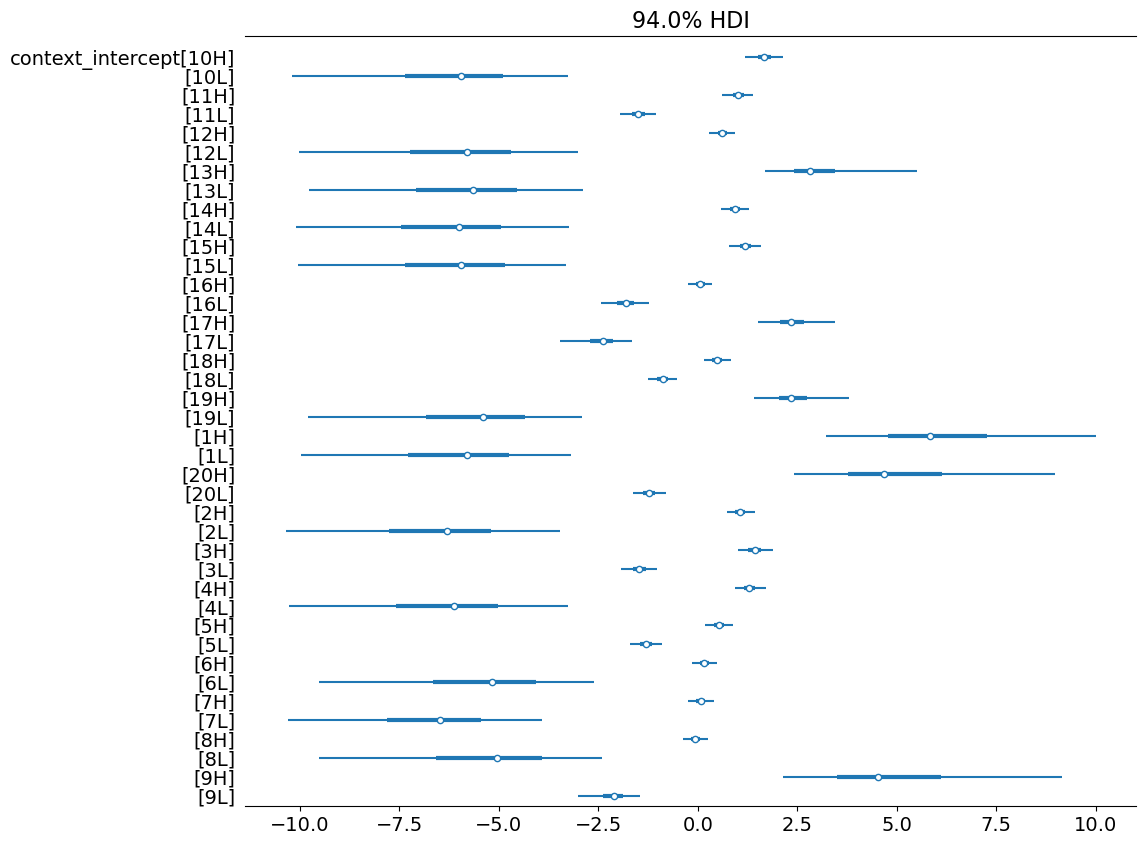

In [136]:
from arviz import plot_forest

_ = plot_forest(
    norming_model.model_fit,
    var_names=["context_intercept"],
    combined=True,
    figsize=(11.5, 10)
)

...and in probability space.

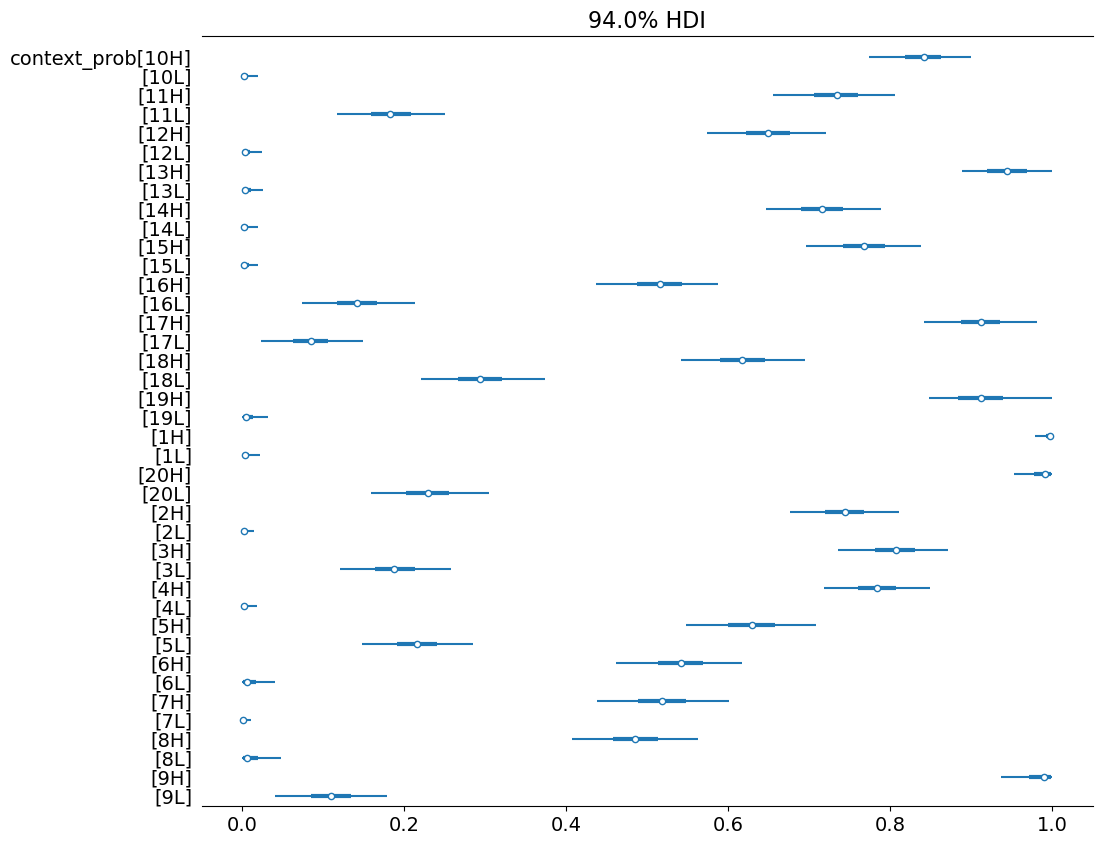

In [137]:
_ = plot_forest(
    norming_model.model_fit,
    var_names=["context_prob"],
    combined=True,
    figsize=(11.5, 10)
)

If we look at the concrete example we looked at [here](model-definition.ipynb#prior-beliefs), we see that these posterior estimates accord with expectation.

In [241]:
from scipy.special import expit
from pandas import merge, melt

# the norming data for 10H and 10L
data_norming_sub = data_norming.query('item.isin(["10H", "10L"])')

# the samples from the posterior for 10H and 10L
samples = DataFrame(
    norming_model.raw_model_fit.stan_variable("context_intercept"),
    columns=norming_model.context_hash_map
)

samples = merge(
    melt(samples, var_name="context", value_name="logodds"), 
    norming_model.context_info
)

samples["prob"] = expit(samples.logodds)

samples["itemType"] = samples.context.map(lambda x: x[-1])

samples_sub = samples.query('context.isin(["10H", "10L"])')

,context,fact,prompt,logodds,prob
0,10H,Zoe is a math major.,How likely is it that Zoe calculated the tip?,1.85264,0.864437
1,10H,Zoe is a math major.,How likely is it that Zoe calculated the tip?,1.72780,0.849131
2,10H,Zoe is a math major.,How likely is it that Zoe calculated the tip?,1.79174,0.857140
3,10H,Zoe is a math major.,How likely is it that Zoe calculated the tip?,1.88675,0.868385
4,10H,Zoe is a math major.,How likely is it that Zoe calculated the tip?,1.72497,0.848768
...,...,...,...,...,...
15995,10L,Zoe is 5 years old.,How likely is it that Zoe calculated the tip?,-7.80021,0.000409
15996,10L,Zoe is 5 years old.,How likely is it that Zoe calculated the tip?,-6.95483,0.000953
15997,10L,Zoe is 5 years old.,How likely is it that Zoe calculated the tip?,-3.82970,0.021255
15998,10L,Zoe is 5 years old.,How likely is it that Zoe calculated the tip?,-5.37417,0.004613


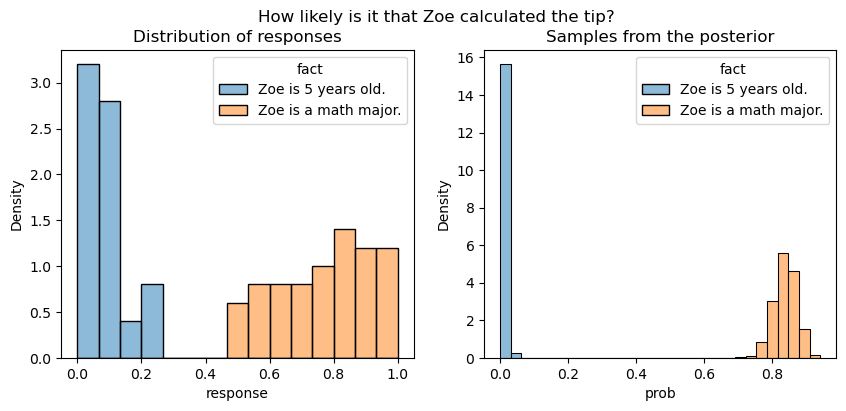

In [251]:
#| code-fold: true
#| code-summary: Plotting code

from matplotlib.pyplot import subplots
from seaborn import histplot

fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 4))
fig.suptitle("How likely is it that Zoe calculated the tip?")

ax1.set_title("Distribution of responses")

p = histplot(
    data=data_norming_sub, x="response", hue="fact", 
    hue_order=["Zoe is 5 years old.", "Zoe is a math major."],
    bins=15,
    ax=ax1,
    stat="density"
)

ax2.set_title("Samples from the posterior")

p = histplot(
    data=samples_sub, x="prob", hue="fact",
    hue_order=["Zoe is 5 years old.", "Zoe is a math major."],
    bins=30,
    ax=ax2,
    stat="density"
)

Note that the posterior samples are for what amounts to the mean response, so we don't expect the distribution of samples to be the same as the distribution of responses.

### Estimating context-specific priors

Our aim in fitting this model is to be able to estimate context-specific priors. Ideally, we could just use the samples from the prior visualized above, but we can't for practical reasons: STAN needs a known functional form for the prior. That is the point of trying to estimate $\mu^\text{context}_c$ and $\sigma^\text{context}_c$ under the assumption that $\rho_c \mid \mathbf{y}_\text{norming} \sim \mathcal{N}(\mu^\text{context}_c, \sigma^\text{context}_c)$.

In [252]:
context_posterior_estimates = norming_model.context_posterior_estimates
context_posterior_estimates["itemType"] = context_posterior_estimates.context.map(lambda x: x[-1])
context_posterior_estimates = context_posterior_estimates.set_index("context")

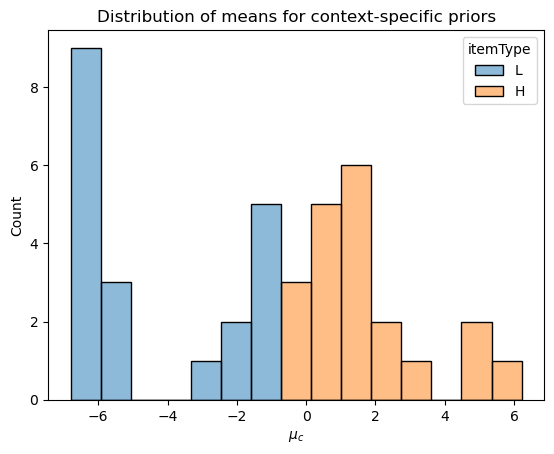

In [256]:
#| code-fold: true
#| code-summary: Plotting code

p = histplot(
    data=context_posterior_estimates, x="context_mean",
    hue="itemType", hue_order=["L", "H"], bins=15
)

p.set_title("Distribution of means for context-specific priors")
_ = p.set_xlabel(r"$\mu_c$")

To assess how good this assumption of normality is, we can compare the empirical CDF derived from the posterior samples with the normal CDF implied by $\mu^\text{context}_c$ and $\sigma^\text{context}_c$ for a particular context $c$.

When $\mu_c$ is in the middle of the scale, the normal approximation is effectively perfect.

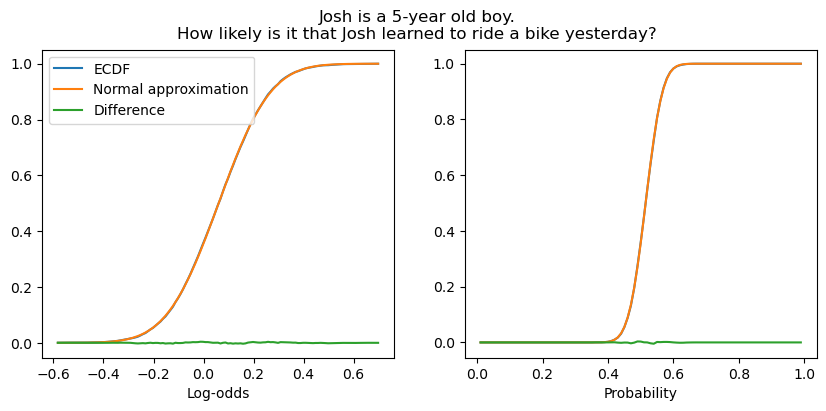

In [267]:
#| code-fold: true
#| code-summary: Plotting code

from numpy import mgrid
from scipy.special import logit
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib.pyplot import subplot, Axes

def plot_context_intercept_posterior(context_id: str, ax: Axes, axis: str="unit", plot_diff: bool=True):
    context_estimates = context_posterior_estimates.loc[context_id]
    
    estimated_dist = norm(context_estimates.context_mean, context_estimates.context_std)
    
    samples = norming_model.raw_model_fit.stan_variable("context_intercept")[:,context_estimates.order]
    
    if axis == "unit":
        x_axis = mgrid[0.01:1:0.01]
        
        samples = expit(samples)
        
        ax.plot(
            x_axis, 
            ECDF(samples)(x_axis),
            label="ECDF"
        )
        
        ax.plot(
            x_axis, 
            estimated_dist.cdf(logit(x_axis)), 
            label="Normal approximation"
        )
    
        if plot_diff:
            ax.plot(
                x_axis, 
                ECDF(samples)(x_axis) - estimated_dist.cdf(logit(x_axis)),
                label="difference"
            )
        
    elif axis=="reals":
        x_axis = mgrid[samples.min():samples.max():0.01]
        
        ax.plot(
            x_axis, 
            ECDF(samples)(x_axis),
            label="ECDF"
        )
        
        ax.plot(
            x_axis, estimated_dist.cdf(x_axis),
            label="Normal approximation"
        )
        
        if plot_diff:
            ax.plot(
                x_axis, 
                ECDF(samples)(x_axis) - estimated_dist.cdf(x_axis),
                label="Difference"
            )
        
    else:
        raise ValueError("'axis' must be \"unit\" or \"reals\".")
    
    return ax

fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 4))
fig.suptitle("Josh is a 5-year old boy.\nHow likely is it that Josh learned to ride a bike yesterday?")

plot_context_intercept_posterior("16H", axis="reals", ax=ax1)
plot_context_intercept_posterior("16H", axis="unit", ax=ax2)

ax1.legend()

ax1.set_xlabel("Log-odds")
_ = ax2.set_xlabel("Probability")

When the likelihood is low, the approximation is slightly worse, though it remains quite good.

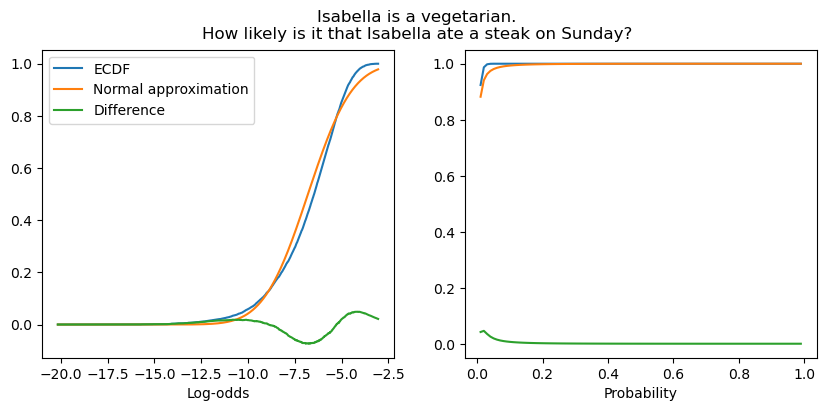

In [273]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 4))
fig.suptitle("Isabella is a vegetarian.\nHow likely is it that Isabella ate a steak on Sunday?")

plot_context_intercept_posterior("7L", axis="reals", ax=ax1)
plot_context_intercept_posterior("7L", axis="unit", ax=ax2)

ax1.legend()

ax1.set_xlabel("Log-odds")
_ = ax2.set_xlabel("Probability")

A similar phenomenon is observed when the mean is high–though, again, the approximation remains quite good.

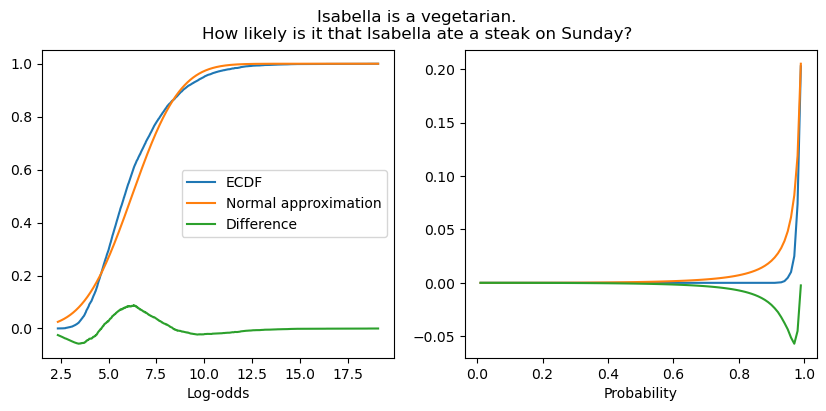

In [274]:
#| code-fold: true
#| code-summary: Plotting code

fig, (ax1, ax2) = subplots(1, 2, figsize=(10, 4))
fig.suptitle("Mary is taking a prenatal yoga class.\nHow likely is it that Mary is pregnant?")

plot_context_intercept_posterior("1H", axis="reals", ax=ax1)
plot_context_intercept_posterior("1H", axis="unit", ax=ax2)

ax1.legend()

ax1.set_xlabel("Log-odds")
_ = ax2.set_xlabel("Probability")

## Models of projection

Turning now to the models of the projection data: we'll also implement these as a subclass of our `StanModel` ABC. Because there are a few different versions of this model we'll want to use–one that uses context-specific priors and another that uses verb-specific priors–we'll need to set this class up in a slightly more complicated way. Basically, we'll store different blocks of STAN code in different files and have class construct the full model specification on the fly based on the parameters to `ProjectionModel.__init__`.

To actually use the estimates for context- or verb-specific priors from some other model fit, we'll additionally need to pass that fit model to `ProjectionModel.__init__`. This makes the initialization logic–as well as the data construction logic–somewhat complex, while keeping the core fitting procedure the same.

In [148]:
from numpy import zeros, ones

@dataclass
class ProjectionData(NormingData):
    N_verb: int                           # number of verbs
    verb: ndarray                         # verb corresponding to response n
    verb_mean: ndarray                    # the verb means inferred from a previous model fit
    verb_std: ndarray                     # the verb standard deviations inferred from a previous model fit
    context_mean: ndarray                 # the context means inferred from the norming data
    context_std: ndarray                  # the context standard deviations inferred from the norming data

In [153]:
from typing import Union

parameters_and_model_block_files = {
    "no_priors_fixed": "parameters-and-model-block.stan",
    "verb_priors_fixed": "parameters-and-model-block-verb-prior-fixed.stan",
    "context_priors_fixed": "parameters-and-model-block-context-prior-fixed.stan",
    "both_priors_fixed": "parameters-and-model-block-context-and-verb-priors-fixed.stan",
}

class ProjectionModel(StanModel):
    stan_data_block_file = "models/projection-model/data-block.stan"
    stan_generated_quantities_block_file = "models/projection-model/generated-quantities-block.stan"
    
    data_class = ProjectionData
    
    def __init__(
        self, prior_model: Optional[Union[NormingModel, 'ProjectionModel']] = None, 
        use_context_prior: bool = True
    ):
        self.prior_model = prior_model
        
        self.use_context_priors = use_context_prior and prior_model is not None
        self.use_verb_priors = hasattr(
            prior_model, "verb_posterior_estimates"
        )
        
        if self.use_context_priors and self.use_verb_priors:
            print("Model initialized with context- and verb-specific priors derived "
                  "from context- and verb-specific posteriors from prior_model.")
            self.context_hash_map = prior_model.context_hash_map
            self.verb_hash_map = prior_model.verb_hash_map
            
            self.stan_parameters_and_model_block_file = os.path.join(
                "models/projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["both_priors_fixed"]
            )
        
        elif self.use_context_priors:
            print("Model initialized with context-specific priors derived "
                  "from context-specific posteriors from prior_model.")
            self.context_hash_map = prior_model.context_hash_map
            
            self.stan_parameters_and_model_block_file = os.path.join(
                "models/projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["context_priors_fixed"]
            )
        
        elif self.use_verb_priors:
            print("Model initialized with verb-specific priors derived "
                  "from verb-specific posteriors from prior_model.")
            self.verb_hash_map = prior_model.verb_hash_map
            
            self.stan_parameters_and_model_block_file = os.path.join(
                "models/projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["verb_priors_fixed"]
            )
            
        else:
            self.stan_parameters_and_model_block_file = os.path.join(
                "models/projection-model/parameters-and-model-block/", 
                parameters_and_model_block_files["no_priors_fixed"]
            )
            
        self._write_stan_file()
            
        super().__init__()
    
    def _write_stan_file(self):
        functions_block = open(self.stan_functions_block_file, "r").read()
        data_block = open(self.stan_data_block_file, "r").read()
        parameters_and_model_block = open(self.stan_parameters_and_model_block_file, "r").read()
        generated_quantities_block = open(self.stan_generated_quantities_block_file, "r").read()
        
        print(f"Writing STAN file to {self.stan_file}...")
        
        with open(self.stan_file, "w") as f:
            f.write(functions_block+"\n\n")
            f.write(data_block+"\n\n")
            f.write(parameters_and_model_block+"\n\n")
            f.write(generated_quantities_block)
    
    @abstractproperty
    def stan_functions_block_file(self):
        raise NotImplementedError
    
    def construct_context_info(self, data: DataFrame):
        if hasattr(self.prior_model, "context_info"):
            self.context_info = self.prior_model.context_info
        else:
            data["prompt"] = data["content"]
            NormingModel.construct_context_info(self, data)
    
    def construct_model_data(self, data: DataFrame):
        self.model_data = NormingModel.construct_model_data(self, data)
        
        if hasattr(self, "verb_hash_map"):
            _, verb_hashed = hash_series(data.verb, self.verb_hash_map)
        else:
            self.verb_hash_map, verb_hashed = hash_series(data.verb)
        
        self.coords.update({
            "verb": self.verb_hash_map
        })
        
        self.dims.update({
            "verb_intercept": ["verb"],
            "verb_prob": ["verb"]
        })
        
        self.model_data.update({
            "N_verb": self.verb_hash_map.shape[0],
            "verb": verb_hashed
        })
        
        if self.use_context_priors:
            self.model_data.update({
                "context_mean": self.context_prior_estimates.context_mean.values,
                "context_std": self.context_prior_estimates.context_std.values
            })
        else:
            self.model_data.update({
                "context_mean": zeros(self.model_data["N_context"]),
                "context_std": ones(self.model_data["N_context"]),
            })
        
        if self.use_verb_priors:
            self.model_data.update({
                "verb_mean": self.verb_prior_estimates.verb_mean.values,
                "verb_std": self.verb_prior_estimates.verb_std.values,
            })
        else:
            self.model_data.update({
                "verb_mean": zeros(self.model_data["N_verb"]),
                "verb_std": ones(self.model_data["N_verb"]),
            })

        return self.model_data
        
    @property
    def context_prior_estimates(self):
        if self.use_context_priors:
            return self.prior_model.context_posterior_estimates
        else:
            raise AttributeError("no prior_model supplied for context priors")
    
    @property
    def context_posterior_estimates(self):
        context_intercept_samples = self.raw_model_fit.stan_variable("context_intercept")

        params = []

        for i in range(context_intercept_samples.shape[1]):
            mu, sigma = norm.fit(context_intercept_samples[:,i])
            context = self.context_hash_map[i]
            params.append([context, mu, sigma])

        params_df = DataFrame(params, columns=["context", "context_mean", "context_std"])
        params_df["order"] = params_df.index
        params_df = merge(params_df, self.context_info).sort_values("order")

        return params_df[["fact", "context", "prompt", "context_mean", "context_std", "order"]]

            
    @property
    def verb_prior_estimates(self):
        if self.use_verb_priors:
            return self.prior_model.verb_posterior_estimates
        else:
            raise AttributeError("prior_model must have verb_posterior_estimates")
            
    @property
    def verb_posterior_estimates(self):
        verb_intercept_samples = self.raw_model_fit.stan_variable("verb_intercept")

        params = []

        for i in range(verb_intercept_samples.shape[1]):
            mu, sigma = norm.fit(verb_intercept_samples[:,i])
            verb = self.verb_hash_map[i]
            params.append([verb, mu, sigma])

        params_df = DataFrame(params, columns=["verb", "verb_mean", "verb_std"])
        params_df["order"] = params_df.index

        return params_df

To implement a particular subtype of projection model, we then simply need to define a subclass that specifies where the `functions` block is located–remember, we factored the models such that they differ only in their definitions of the likelihood function–and where to write the full model code out to. 

In [154]:
class FullyDiscreteProjectionModel(ProjectionModel):
    stan_functions_block_file = "models/projection-model/fully-discrete/fully-discrete-likelihoods.stan"
    stan_file = "models/projection-model/fully-discrete/fully-discrete-model.stan"
    
class VerbDiscreteProjectionModel(ProjectionModel):
    stan_functions_block_file = "models/projection-model/verb-discrete/verb-discrete-likelihoods.stan"
    stan_file = "models/projection-model/verb-discrete/verb-discrete-model.stan"

class ContextDiscreteProjectionModel(ProjectionModel):
    stan_functions_block_file = "models/projection-model/context-discrete/context-discrete-likelihoods.stan"
    stan_file = "models/projection-model/context-discrete/context-discrete-model.stan"

class FullyGradientProjectionModel(ProjectionModel):
    stan_functions_block_file = "models/projection-model/fully-gradient/fully-gradient-likelihoods.stan"
    stan_file = "models/projection-model/fully-gradient/fully-gradient-model.stan"

In [215]:
#| code-fold: true
#| code-summary: Load norming data

def load_projection_data(fname: str) -> DataFrame:
    data = read_csv(fname, index_col=0)
    
    if "comments" in data.columns:
        data = data.drop(columns="comments")

    data = data[data.trigger_class != "control"]

    data["itemType"] = data.fact_type.str.replace("fact", "")
    data["item"] = data.contentNr.astype(str) + data.fact_type.str.replace("fact", "")
    
    return data

data_projection = load_projection_data(
    os.path.join(
        data_dir, 
        "projective-probability/results/3-projectivity/data/cd.csv"
    )
)

### Fitting the model

We can then fit each of the models. We'll look at what different models learn about the verbs in more detail once we've fit them all and run our model comparison.

In [ ]:
fully_discrete_projection_model = FullyDiscreteProjectionModel(norming_model)
_ = fully_discrete_projection_model.fit(data_projection)

In [ ]:
verb_discrete_projection_model = VerbDiscreteProjectionModel(norming_model)
_ = verb_discrete_projection_model.fit(data_projection)

In [ ]:
context_discrete_projection_model = ContextDiscreteProjectionModel(norming_model)
context_discrete_projection_model.fit(data_projection)

In [ ]:
fully_gradient_projection_model = FullyGradientProjectionModel(norming_model)
_ = fully_gradient_projection_model.fit(data_projection)

### Model comparison

We can now run model comparison.

In [177]:
from arviz import compare, plot_compare

models = {
    "Verb Discrete\nContext Discrete": fully_discrete_projection_model,
    "Verb Discrete\nContext Gradient": verb_discrete_projection_model,
    "Verb Gradient\nContext Discrete": context_discrete_projection_model,
    "Verb Gradient\nContext Gradient": fully_gradient_projection_model
}

projection_model_comparison = compare({
    m_name: m.model_fit for m_name, m in models.items()
})

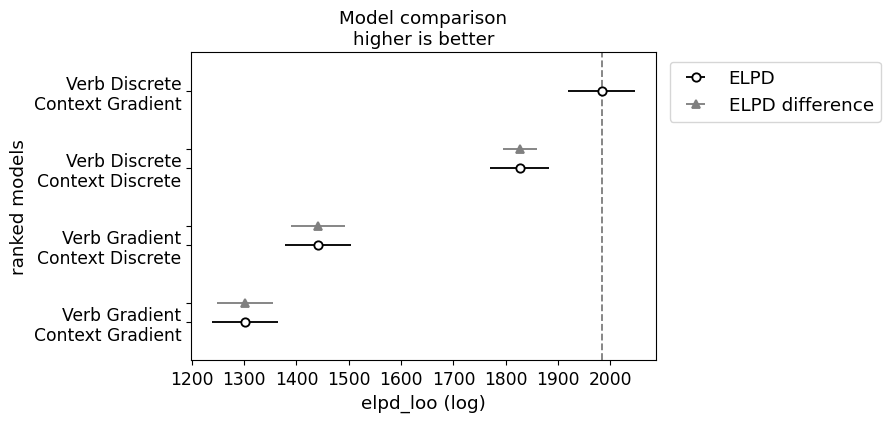

In [177]:
#| code-fold: true
#| code-summary: Plotting code

_ = plot_compare(projection_model_comparison)

The main thing to note here is that both models associated with the [indeterminacy hypothesis](model-definition.ipynb#two-versions-of-the-indeterminacy-hypothesis) dominate both models associated with the [fundamental gradience hypothesis](model-definition.ipynb#two-versions-of-the-fundamental-gradience-hypothesis), with the verb discrete model performing the best by far.

### Investigating the fits

We can now turn to understanding how each model fits the data. To do this, we can look at the probabilities associated with each verb.

In [187]:
from pandas import concat

verb_probs = []
 
for m_name, m in models.items():
    verb_probs_sub = DataFrame(
        m.raw_model_fit.stan_variable("verb_prob"),
        columns=m.verb_hash_map
    )
    
    verb_probs_sub["model"] = m_name
    
    verb_probs.append(verb_probs_sub)
    
verb_probs = concat(verb_probs)

verb_probs = melt(verb_probs, id_vars="model")

,model,variable,value
0,Verb Discrete\nContext Discrete,acknowledge,2.699850e-01
1,Verb Discrete\nContext Discrete,acknowledge,2.912600e-01
2,Verb Discrete\nContext Discrete,acknowledge,2.696550e-01
3,Verb Discrete\nContext Discrete,acknowledge,1.921890e-01
4,Verb Discrete\nContext Discrete,acknowledge,2.014510e-01
...,...,...,...
639995,Verb Gradient\nContext Gradient,think,4.363940e-22
639996,Verb Gradient\nContext Gradient,think,6.227660e-15
639997,Verb Gradient\nContext Gradient,think,1.147610e-17
639998,Verb Gradient\nContext Gradient,think,1.003010e-17


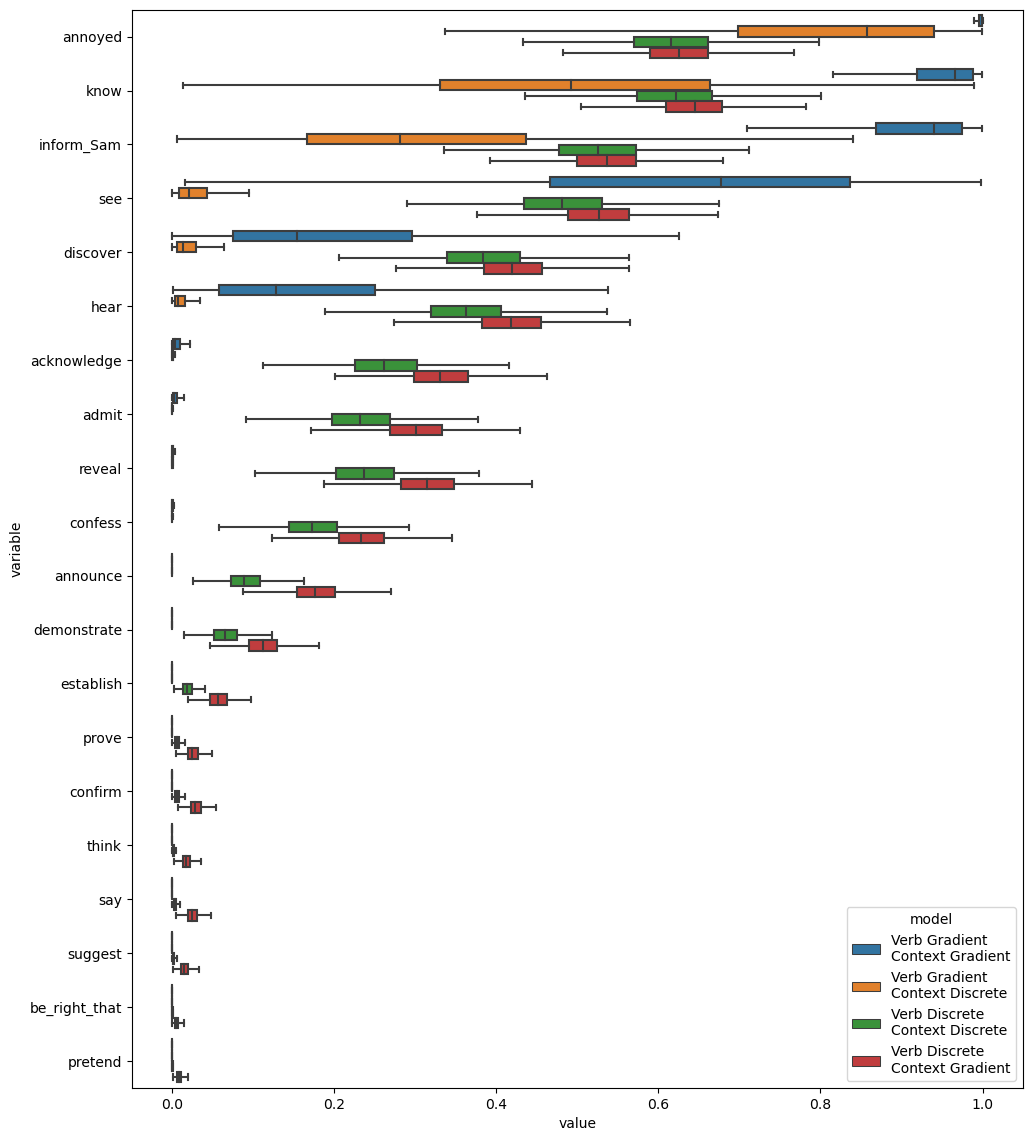

In [197]:
#| code-fold: true
#| code-summary: Plotting code

from matplotlib.pyplot import subplots
from seaborn import boxplot

verb_probs_fully_gradient = verb_probs[verb_probs.model=="Verb Gradient\nContext Gradient"]

verb_order = verb_probs_fully_gradient.groupby("variable")["value"].mean()
verb_order = verb_order.sort_values(ascending=False)

model_order = verb_probs.groupby("model")["value"].max()
model_order = model_order.sort_values(ascending=False)

fig, ax = subplots(figsize=(11.5, 14))

_ = boxplot(
    verb_probs, 
    x="value", y="variable", hue="model",
    order=verb_order.index, 
    hue_order=model_order.index,
    fliersize=0., ax=ax)

One interesting thing to note here is that both the fully gradient model (verb gradient-context gradient) and the contrext discrete model (verb gradient-context discrete) tend to have much more extreme probabilities associated with each verb than the two other models. We can see this pattern even more clearly if we plot the mean value for each verb. 

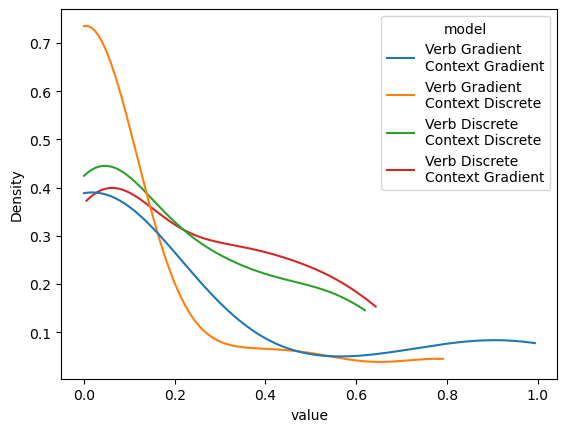

In [210]:
#| code-fold: true
#| code-summary: Plotting code

from seaborn import kdeplot

mean_verb_probs_by_model = verb_probs.groupby(["model", "variable"]).value.mean().reset_index()

_ = kdeplot(
    mean_verb_probs_by_model, 
    x="value", hue="model", 
    cut=0., hue_order=model_order.index
)

What this pattern would seem to suggest is that the two models associated with the fundamental gradience hypothesis are, in some sense, trying to simulate those associated with the indeterminacy hypothesis.

Conversely, the probabilities associated with the models associated with the indeterminacy hypothesis, suggest much more variability in projectivity–consistent with the original observation by @white_role_2018 and the later observations by @degen_factive_2022 and @kane_intensional_2022. Putting the findings of @kane_intensional_2022 together with these findings would seem to lend strong support to the indeterminacy hypothesis.

## Modeling the bleached and templatic data

To further evaluate these models, let's fit the variants [discussed in the last section](model-definition.ipynb#additional-experiments) to the bleached and templatic datasets. The main change in how we fit these models–compared to the models we fit to Degen and Tonhauser data–is that we'll use the models fit to their data to determine the verb-specific priors on the by-verb random intercepts.

### Modeling the bleached data

First, we'll fit to the bleached data. 

In [216]:
#| code-fold: true
#| code-summary: Load bleached data

data_projection_bleached = load_projection_data(
    os.path.join(
        data_dir, 
        "projective-probability-replication/bleached.csv"
    )
)

data_projection_bleached["workerid"] = data_projection_bleached.participant

In [ ]:
fully_discrete_projection_model_bleached = FullyDiscreteProjectionModel(
    fully_discrete_projection_model, use_context_prior=False
)
fully_discrete_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False,
)

In [ ]:
verb_discrete_projection_model_bleached = VerbDiscreteProjectionModel(
    verb_discrete_projection_model, use_context_prior=False
)
verb_discrete_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False,
)

In [ ]:
context_discrete_projection_model_bleached = ContextDiscreteProjectionModel(
    context_discrete_projection_model, use_context_prior=False
)
context_discrete_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False,
)

In [ ]:
fully_gradient_projection_model_bleached = FullyGradientProjectionModel(
    fully_gradient_projection_model, use_context_prior=False
)
fully_gradient_projection_model_bleached.fit(
    data_projection_bleached, map_initialization=False,
)

In running the model comparison, we observe the same pattern of results we observed for Degen and Tonhauser's data.

In [221]:
projection_model_bleached_comparison = compare({
    "Verb Discrete\nContext Discrete": fully_discrete_projection_model_bleached.model_fit,
    "Verb Discrete\nContext Gradient": verb_discrete_projection_model_bleached.model_fit,
    "Verb Gradient\nContext Discrete": context_discrete_projection_model_bleached.model_fit,
    "Verb Gradient\nContext Gradient": fully_gradient_projection_model_bleached.model_fit
})

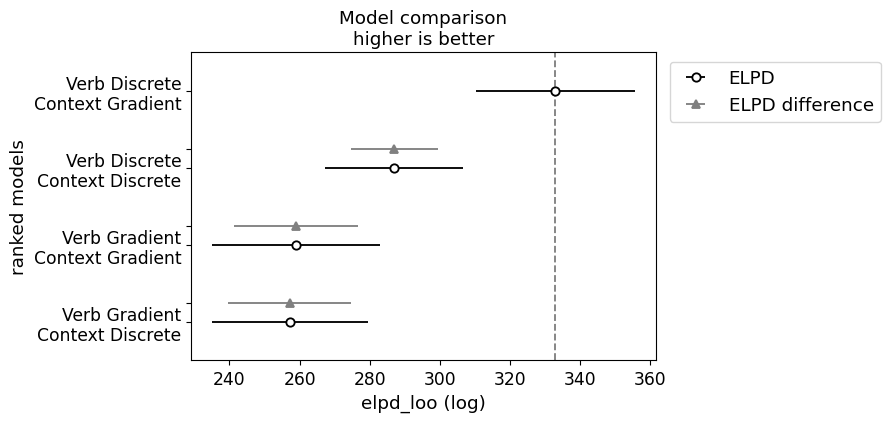

In [222]:
#| code-fold: true
#| code-summary: Plotting code

_ = plot_compare(projection_model_bleached_comparison)

We can also see that the standard deviation of the by-context intercepts is extremely small–especially compared to the standard deviations of the by-subject intercepts.^[Remember that this standard deviation is in log-odds space.]

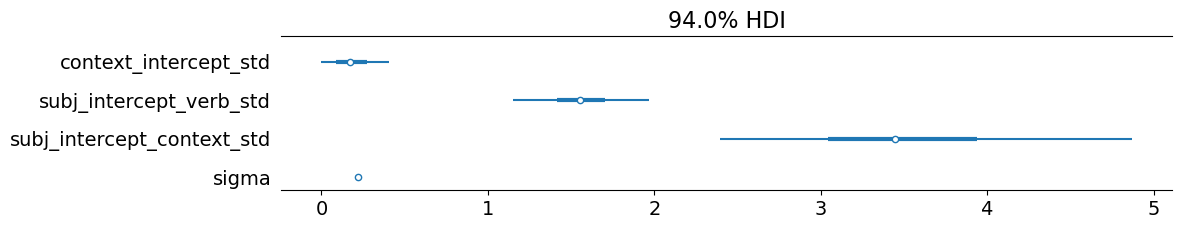

In [227]:
#| code-fold: true
#| code-summary: Plotting code

_ = plot_forest(
    verb_discrete_projection_model_bleached.model_fit,
    var_names=["context_intercept_std", "subj_intercept_verb_std", "subj_intercept_context_std"],
    combined=True,
    figsize=(11.5, 2),
)

This small standard deviation is what we should expect here: one cannot in fact have prior beliefs about the beliefs contexts, so subjects just assume that the bleached content has a roughly 50-50 chance of being true.

### Modeling the templatic data

We'll do the same for the templatic data.

In [229]:
#| code-fold: true
#| code-summary: Load templatic data

data_projection_templatic = load_projection_data(
    os.path.join(
        data_dir, 
        "projective-probability-replication/templatic.csv"
    )
)

data_projection_templatic["workerid"] = data_projection_templatic.participant

In [ ]:
fully_discrete_projection_model_templatic = FullyDiscreteProjectionModel(
    fully_discrete_projection_model, use_context_prior=False
)
_ = fully_discrete_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False,
)

In [ ]:
verb_discrete_projection_model_templatic = VerbDiscreteProjectionModel(
    verb_discrete_projection_model, use_context_prior=False
)
_ = verb_discrete_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False,
)

In [ ]:
context_discrete_projection_model_templatic = ContextDiscreteProjectionModel(
    context_discrete_projection_model, use_context_prior=False
)
_ = context_discrete_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False,
)

In [ ]:
fully_gradient_projection_model_templatic = FullyGradientProjectionModel(
    fully_gradient_projection_model, use_context_prior=False
)
_ = fully_gradient_projection_model_templatic.fit(
    data_projection_templatic, map_initialization=False, 
)

In [235]:
projection_model_templatic_comparison = compare({
    "Verb Discrete\nContext Discrete": fully_discrete_projection_model_templatic.model_fit,
    "Verb Discrete\nContext Gradient": verb_discrete_projection_model_templatic.model_fit,
    "Verb Gradient\nContext Discrete": context_discrete_projection_model_templatic.model_fit,
    "Verb Gradient\nContext Gradient": fully_gradient_projection_model_templatic.model_fit
})

In running this model comparison, we observe a similar pattern of results, with the verb discrete model pulling even father ahead.

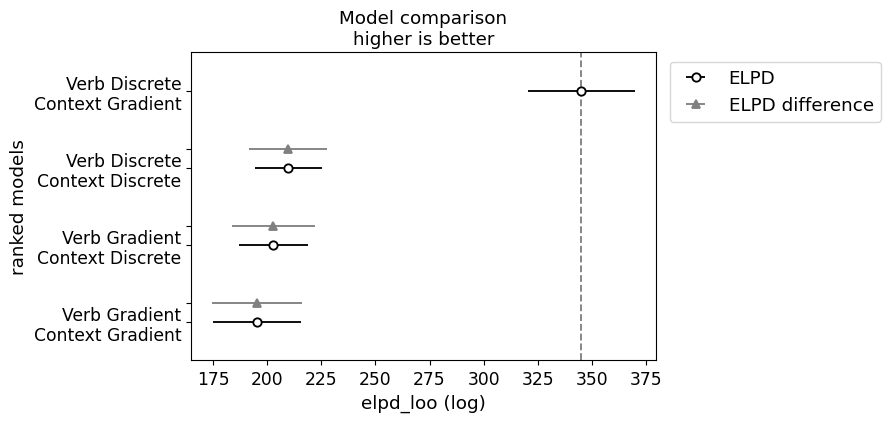

In [236]:
#| code-fold: true
#| code-summary: Plotting code

_ = plot_compare(projection_model_templatic_comparison)

As expected, we also observe that the standard deviation of the by-context intercepts is extremely small, which we expect for the same reasons we expected in for the models fit to the bleached data.

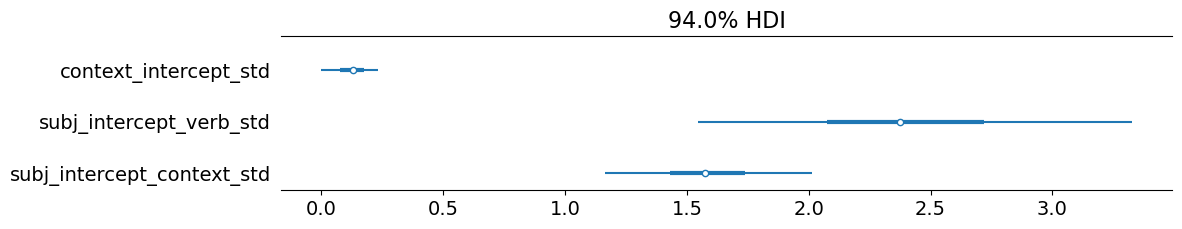

In [278]:
#| code-fold: true
#| code-summary: Plotting code

_ = plot_forest(
    verb_discrete_projection_model_templatic.model_fit,
    var_names=["context_intercept_std", "subj_intercept_verb_std", "subj_intercept_context_std"],
    combined=True,
    figsize=(11.5, 2),
)

## Summing up

In this module, we considered two subtly distinct questions: (i) whether there is evidence for discrete classes of lexical representations that determine inferences commonly associated with factive predicates or whether this knowledge is fundamentally continuous; and (ii) how, for aspects of lexical knowledge that are fundamentally continuous, that knowledge is integrated with world knowledge. Relevant to the first question, we saw evidence from @kane_intensional_2022 that, when we appropriately account for various sources of gradience in inference judgments, we observe a small number of clear cluster of predicates, all of which correspond cleanly to the predicate classes one might expect from the literature of clause-embedding predicates and a subset of which correspond to traditional subclassifications of factives. To address the second question, we modeled data collected by @degen_prior_2021 showing that models assuming that gradience comes from indeterminacy outperform models that assume fundamental gradience. 